#### generate TPU index

In [34]:
import pandas as pd

In [35]:
data_path = "Q:/DATA/SPRAI/Chengyu Huang/8_Data_Science/Factiva_News_Project/data/results/merged/TPU_aggregated_data.pkl"
df = pd.read_pickle(data_path)

In [41]:
# Extract year and month from the publication date
df['pub_year'] = df['ILA_publication_date'].dt.year
df['pub_month'] = df['ILA_publication_date'].dt.month
df['pub_period'] = df['ILA_publication_date'].dt.to_period('M')
# Sort articles by publication date
df.sort_values(by='ILA_publication_date', inplace=True)

In [42]:
df.head()

,id,ILA_publication_date,ILA_WordCount,ILA_SentenceCount,ILA_RulebasedCountryTag,ILA_TradeTopicTag,ILA_TradeTopicKeywords,ILA_TradeTopicKeywordCount,ILA_original_filename,ILA_TPU_Flag,ILA_TPU_Reference,pub_year,pub_month,pub_period
22,RDV0000020060201e2110000a,2006-01-01,5183,506,[],True,"[supply chain, import, trade, commerce]",4,2005_articles_1.json,False,,2006,1,2006-01
325,AGEFIL0020060208e2110000o,2006-01-01,565,18,"[lebanon, luxembourg]",False,[],0,2005_articles_23.json,False,,2006,1,2006-01
324,BKNA000020060131e2110000r,2006-01-01,1310,61,[],True,[import],1,2005_articles_23.json,False,,2006,1,2006-01
323,SOUSTD0020060101e2110000f,2006-01-01,450,26,[],False,[],0,2005_articles_23.json,False,,2006,1,2006-01
322,SCMP000020051231e2110000x,2006-01-01,775,36,[united states of america],True,"[imports, tariff, trade, import, global trade,...",7,2005_articles_23.json,False,,2006,1,2006-01


<Axes: title={'center': 'Number of Articles Published Over Time'}, xlabel='pub_period'>

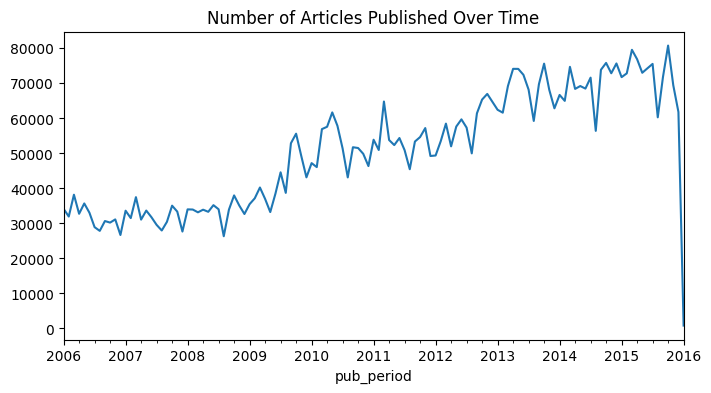

In [43]:
df.pub_period.value_counts().sort_index().plot(kind='line', figsize=(8, 4), title='Number of Articles Published Over Time')

In [44]:
# Step 2: Define a function to compute the TPU index by time period (or any group)
def compute_tpu_index_grouped(df, group_cols=['pub_date_readable'], id_col='id', flag_col='ILA_TPU_Flag', freq='M'):
    df = df.copy()
    # Convert to datetime if grouping by date column
    if 'pub_date_readable' in group_cols:
        df['pub_date_readable'] = pd.to_datetime(df['pub_date_readable'])
        if freq:
            # Convert to period, then back to timestamp for grouping
            df['period'] = df['pub_date_readable'].dt.to_period(freq).dt.to_timestamp()
            group_cols = ['period'] + [col for col in group_cols if col != 'pub_date_readable']
    # Group by selected columns and compute total articles and TPU-flagged articles
    grouped = df.groupby(group_cols).agg(
        NUMBER_ARTICLES=(id_col, 'count'),
        TPUD_ARTICLES=(flag_col, 'sum')
    ).reset_index()

    # Compute TPU index as percentage
    grouped['TPUD_index'] = (grouped['TPUD_ARTICLES'] / grouped['NUMBER_ARTICLES'] * 100).round(2)

    # Ensure article counts are integer type
    grouped['NUMBER_ARTICLES'] = grouped['NUMBER_ARTICLES'].astype(int)
    grouped['TPUD_ARTICLES'] = grouped['TPUD_ARTICLES'].astype(int)

    return grouped

<Axes: title={'center': 'Global TPU Index Over Time'}, xlabel='Publication Period', ylabel='TPU Index (%)'>

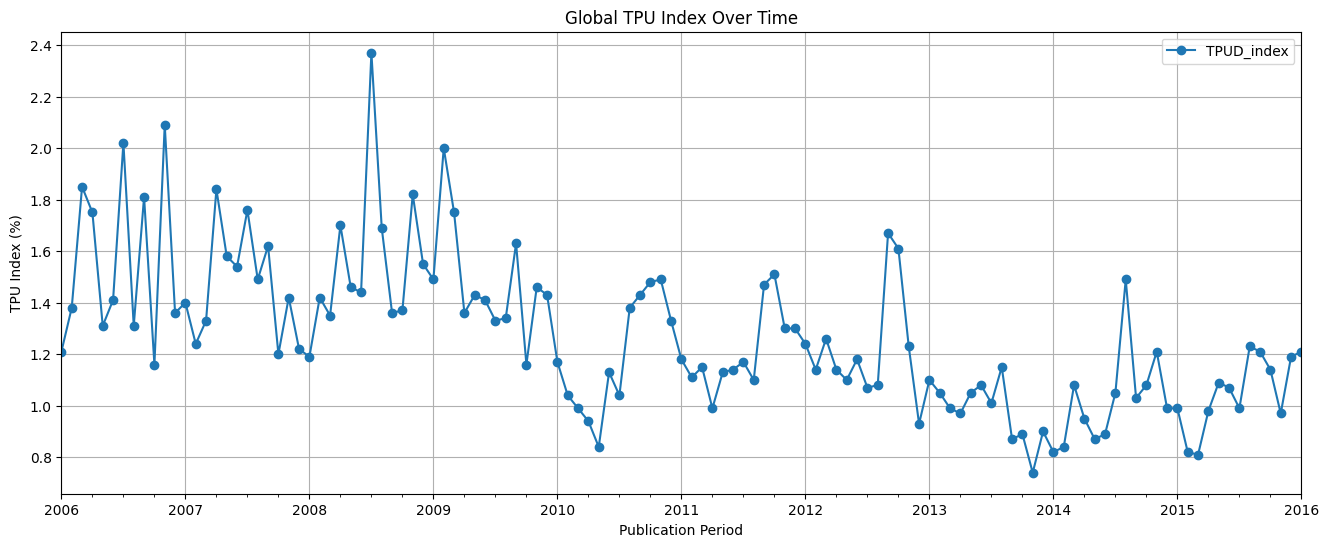

In [53]:
TPU_df = compute_tpu_index_grouped(df, group_cols=['pub_period'])
TPU_df.plot(
    x='pub_period',
    y='TPUD_index',
    kind='line',
    marker='o',
    title='Global TPU Index Over Time',
    xlabel='Publication Period',
    ylabel='TPU Index (%)',
    grid=True,
    figsize=(16, 6)
)

In [46]:
def get_all_countries(df,country_col='ILA_RulebasedCountryTag'):
    unique_countries = set()
    for tags in df[country_col]:
        unique_countries.update(tags)
    unique_countries = sorted(unique_countries)
    unique_countries = [country for country in unique_countries if country != '']
    return unique_countries

countries = get_all_countries(df)

In [47]:
def get_TPU_index_by_country(df, country_name):
    df = df.copy()
    df['country_flag'] = df['ILA_RulebasedCountryTag'].apply(lambda tags: country_name in tags)
    df = df[df['country_flag']]
    Country_TPU_df = compute_tpu_index_grouped(df, group_cols=['pub_period'])
    return Country_TPU_df

In [52]:
print(countries)

['afghanistan', 'albania', 'algeria', 'american samoa', 'andorra', 'angola', 'anguilla', 'antigua and barbuda', 'argentina', 'armenia', 'aruba', 'australia', 'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 'belize', 'benin', 'bermuda', 'bhutan', 'bolivia', 'bosnia and herzegovina', 'botswana', 'brazil', 'british indian ocean territory', 'british virgin islands', 'brunei darussalam', 'bulgaria', 'burkina faso', 'burundi', 'cambodia', 'cameroon', 'canada', 'cape verde', 'cayman islands', 'central african republic', 'chad', 'chile', 'china', 'christmas island', 'cocos islands', 'colombia', 'comoros', 'congo', 'cook islands', 'costa rica', "cote d'ivoire", 'croatia', 'croatian republic of herzeg/bosnia', 'cyprus', 'czech republic', 'democratic republic of the congo', 'denmark', 'djibouti', 'dominica', 'dominican republic', 'ecuador', 'egypt', 'el salvador', 'equatorial guinea', 'eritrea', 'estonia', 'ethiopia', 'faeroe islands', 'falkland isla

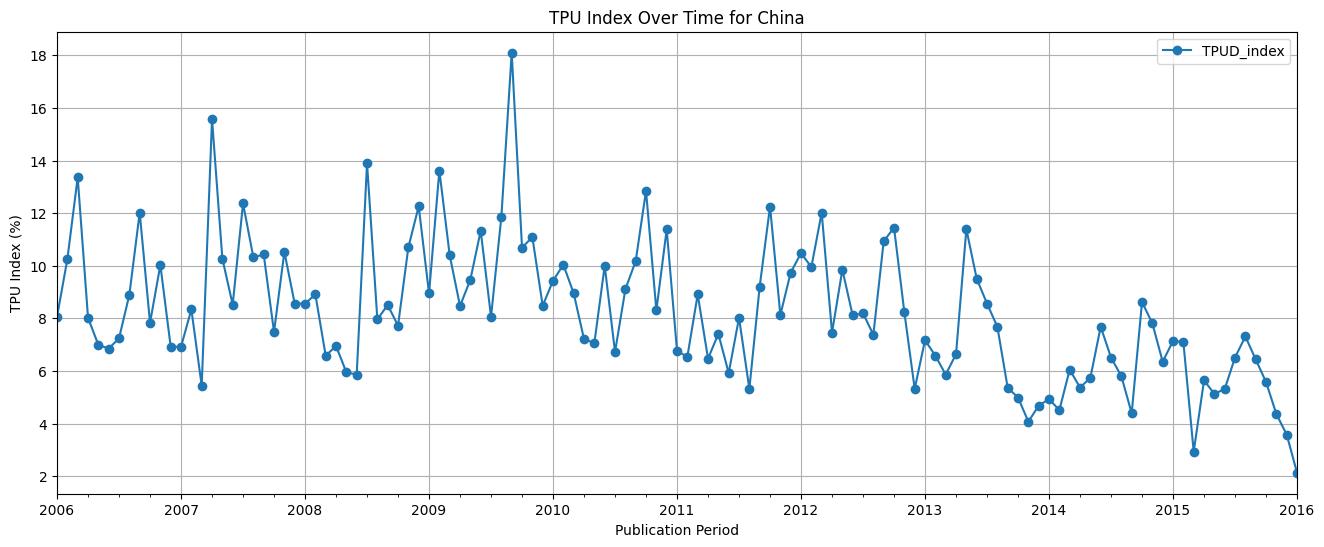

In [50]:
country_name = 'China'
if country_name.lower() in countries:
    country_TPU_df = get_TPU_index_by_country(df, country_name.lower())
    country_TPU_df.plot(
        x='pub_period',
        y='TPUD_index',
        kind='line',
        marker='o',
        title=f'TPU Index Over Time for {country_name}',
        xlabel='Publication Period',
        ylabel='TPU Index (%)',
        grid=True,
        figsize=(16, 6)
    )

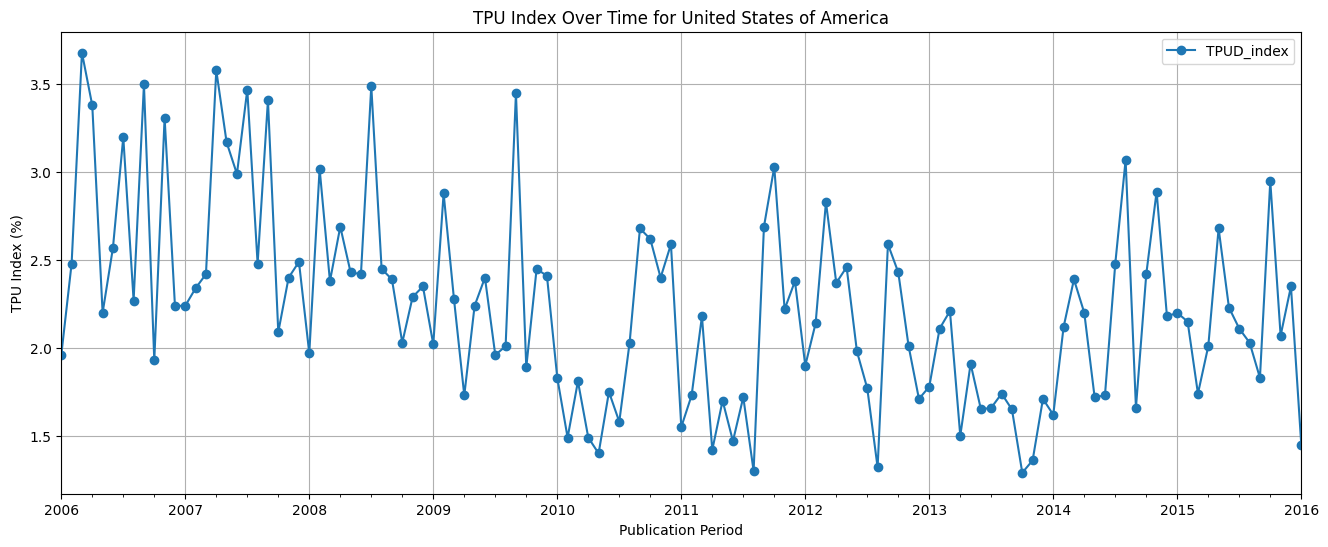

In [51]:
country_name = 'United States of America'
if country_name.lower() in countries:
    country_TPU_df = get_TPU_index_by_country(df, country_name.lower())
    country_TPU_df.plot(
        x='pub_period',
        y='TPUD_index',
        kind='line',
        marker='o',
        title=f'TPU Index Over Time for {country_name}',
        xlabel='Publication Period',
        ylabel='TPU Index (%)',
        grid=True,
        figsize=(16, 6)
    )